#Pecan ranking analysis

Here we perform analysis on the model vs ground truth data for thermal and occupancy consumption. We contrast two models:
* ground truth thermal response: a locally-weighted regression model using separately-monitored HVAC and temperature
* the HMM thermal model

##Initializations

In [15]:
rm(list = ls())

In [16]:
options(error = recover)
library('segmented')
library('lubridate')
library('ggplot2')
library(zoo)
library('reshape2')
library('PerformanceAnalytics')
library('RColorBrewer')
library('pracma')
library('fields')
library(gplots)

In [17]:
setwd("~/EnergyAnalytics/thermal_profiles/")
source("validator/drank.r")

In [18]:
DATA_PATH = '~/S3L_server/energy-data/pecan_street/usage-select/'
DUMP_PATH = '~/S3L_server/energy-data/pecan_street/models_2/'
PLOT_PATH = '~/S3L_server/plots/pecan-street-2/'
MODEL_PATH= '~/S3L_server/energy-data/pecan_street/models_2/'

In [19]:
load(paste(MODEL_PATH, "all_model_results.RData", sep=''))

In [20]:
names(thermal_model)

NULL

In [21]:
str(thermal_model[[1]])

'data.frame':	120 obs. of  22 variables:
 $ Temperature   : int  1 2 3 4 5 6 7 8 9 10 ...
 $ resp_avg      : num  0.00357 0.00353 0.0035 0.00347 0.00343 ...
 $ resp_avg.se   : num  0.000224 0.000223 0.000223 0.000222 0.000221 ...
 $ resp_MAP      : num  0.008492 0.008492 0.008492 0.008492 0.000365 ...
 $ resp_MAP.se   : num  4.45e-04 4.45e-04 4.45e-04 4.45e-04 1.93e-05 ...
 $ X1            : num  0.365 0.361 0.357 0.354 0.351 ...
 $ X2            : num  0.265 0.274 0.282 0.291 0.298 ...
 $ X3            : num  0.37 0.365 0.361 0.356 0.35 ...
 $ fit_HVAC      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ resp_HVAC     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ fit_HV        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ resp_HV       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ fit_AC        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ resp_AC       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ grain         : Factor w/ 1 level "60min": 1 1 1 1 1 1 1 1 1 1 ...
 $ name          : Factor w/ 301 levels "Aaron","Abner",..: 71 71 71 71 71 71 71 71 71 71 ...


In [22]:
# glue together all the response profiles
thermal_model_df = lapply(thermal_model, function(df) {
    xcols = grepl("X[1-9]", names(df))
    tmp = df[,!xcols]
    return(tmp)
})
thermal_model_df = do.call("rbind", thermal_model_df)

# get number of states for each consumer
no_states = sapply(thermal_model, function(df) {
    xcols = grepl("X[1-9]", names(df))
    return(c(name=as.character(df[1,"name"]), 
             UID=as.character(df[1,'UID']), 
             grain=as.character(df[1,'grain']), 
             nStates=sum(xcols)))
})
no_states = data.frame(t(no_states))
no_states$nStates = as.numeric(as.character(no_states$nStates))

In [23]:
head(thermal_model_df)

,Temperature,resp_avg,resp_avg.se,resp_MAP,resp_MAP.se,fit_HVAC,resp_HVAC,fit_HV,resp_HV,fit_AC,resp_AC,grain,name,UID,Temperature_BP,resp_HV_BP,resp_AC_BP,resp_HVAC_BP,resp_avg.1
1,1,0.003567264,0.0002236068,0.008491755,0.0004452999,0,0,0,0,0,0,60min,Edd,1069,1,0.001191455,0,0.001191455,0.003533927
2,2,0.003533927,0.0002231051,0.008491755,0.0004452999,0,0,0,0,0,0,60min,Edd,1069,2,0.001191455,0,0.001191455,0.003500119
3,3,0.003500119,0.0002225335,0.008491755,0.0004452999,0,0,0,0,0,0,60min,Edd,1069,3,0.001191455,0,0.001191455,0.003465684
4,4,0.003465684,0.0002218744,0.008491755,0.0004452999,0,0,0,0,0,0,60min,Edd,1069,4,0.001191455,0,0.001191455,0.003430407
5,5,0.003430407,0.0002211072,0.0003645379,1.930316e-05,0,0,0,0,0,0,60min,Edd,1069,5,0.001191455,0,0.001191455,0.003394007
6,6,0.003394007,0.0002202074,0.0003645379,1.930316e-05,0,0,0,0,0,0,60min,Edd,1069,6,0.001191455,0,0.001191455,0.003356136


In [24]:
head(no_states)

,name,UID,grain,nStates
1,Edd,1069,60min,3
2,Emery,1086,60min,2
3,Grant,1105,60min,3
4,James,114,60min,3
5,Jerome,1167,60min,2
6,George,1169,60min,4


##Ranking analysis: cumulative average response

First we can sort the consumers according to the response and pick the best K.

In [25]:
temp = c(80,82)
produce_plot=TRUE
var_model=c(TR="resp_avg", BP="resp_HVAC_BP")
var_truth="resp_HVAC"
res="60min"

In [26]:
thermal_model_df$grain = as.character(thermal_model_df$grain)
cur_df = subset(thermal_model_df, (Temperature >= temp[1]) & (Temperature <= temp[2]) & (grain==res),
                    select=c("name", "Temperature", "grain", var_truth, var_model))
    cur_df_mu = t(sapply(split(cur_df,cur_df$name), function(chunk) colMeans(chunk[,c(var_model, var_truth)])))
    cur_df_sd = t(sapply(split(cur_df,cur_df$name), function(chunk) apply(chunk[,c(var_model, var_truth)],2,sd)))
    cur_df_mu[is.na(cur_df_mu)] <- 0
    mod_idx = order(-abs(cur_df_mu[,var_model])) # sort according to the model
    gth_idx = order(-abs(cur_df_mu[,var_truth])) # sort according to ground truth
    K = nrow(cur_df_mu)


In [27]:
colSums(cur_df_mu, na.rm=T)

resp_avg resp_HVAC_BP    resp_HVAC 
    2.787739     4.037246     8.283247

In [119]:
rank_contrib_at_k = function(thermal_model_df, 
                          temp = c(80,82), produce_plot=TRUE,
                          var_model=c(TR="resp_avg", BP="resp_HVAC_BP"), var_truth="resp_HVAC", res="60min"){
    thermal_model_df$grain = as.character(thermal_model_df$grain)
    cur_df = subset(thermal_model_df, (Temperature >= temp[1]) & (Temperature <= temp[2]) & (grain==res),
                    select=c("name", "Temperature", "grain", var_truth, var_model))
    cur_df_mu = t(sapply(split(cur_df,cur_df$name), function(chunk) colMeans(chunk[,c(var_model, var_truth)])))
    cur_df_mu[is.na(cur_df_mu)] <- 0
    
    # plot reference ground truth
    gth_idx = order(-abs(cur_df_mu[,var_truth])) # sort according to ground truth
    gth_resp    = cur_df_mu[gth_idx,var_truth]
    ylim = c(0, 1.1*sum(abs(cur_df_mu[,var_truth]), na.rm=T))
    if (produce_plot) {
        plot(1:K, cumsum(abs(gth_resp)), lwd=4, col="red", lty=1, ylim=ylim, type='l',
            main=sprintf("Cumulative Response Ranking T=%d F", temp[1], temp[2]),
            xlab="Number of Consumers Selected (n)",
            ylab="Agg. Response [kW/F]",
            cex.lab=2,
            cex.main=2,
            cex.axis=2)
            lines(1:K, (1:K)*mean(abs(gth_resp), na.rm=T), lty=2, col="red", lwd=3)
    }
      
    cum_rel_err_lst = list()
    j = 0
    for (vm in var_model) {
        j = j + 1
        mod_idx = order(-abs(cur_df_mu[,vm])) # sort according to the model
        K = nrow(cur_df_mu)
        #mod_idx = mod_idx[-1]
        mod_resp    = cur_df_mu[mod_idx,vm]
        ref_resp    = cur_df_mu[mod_idx,var_truth]
        cum_abs_err = abs(cumsum(abs(gth_resp)) - cumsum(abs(ref_resp)))
        cum_rel_err = cum_abs_err / cumsum(abs(gth_resp))
        cum_rel_err_lst[[vm]] = cum_rel_err
        # produce plot
        if (produce_plot) {
            lines(1:K, cumsum(abs(ref_resp)), lwd=4, col=rgb(0,0,0,1), lty=j)
            polygon(c(1:K, rev(1:K)), 
                    c(cumsum(abs(gth_resp)), rev(cumsum(abs(ref_resp)))),
                    col=rgb(1,0,0,0.1), border=NA)
        }
    }
    if (produce_plot)  
        legend("bottomright", c("True (Ranked)", "True (Random)", paste(names(var_model), "(Ranked)")), 
                   col=c("red", "red", rep("black", length(var_model))), lty=c(1,2,1:(1+length(var_model))), lwd=2)   

    # compute quantities to return
    return(cum_rel_err_lst)
}


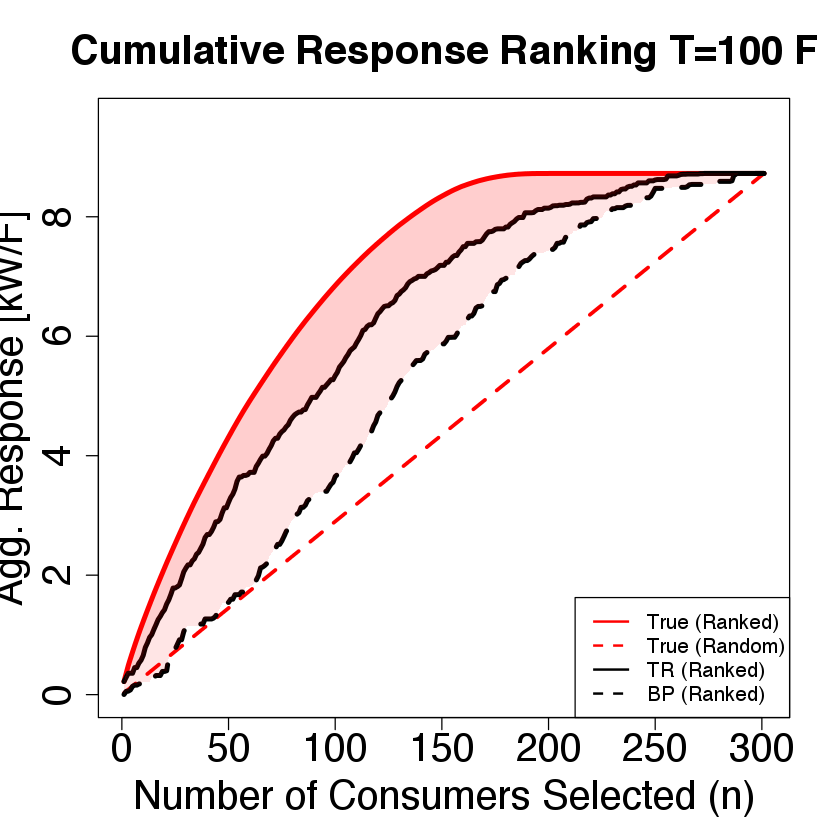

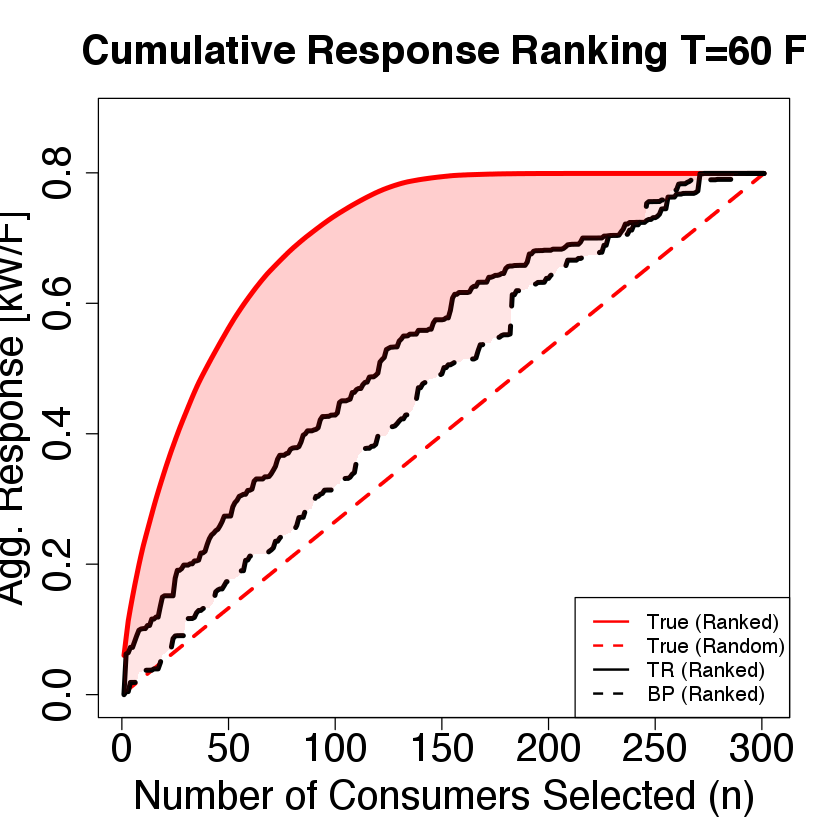

In [120]:
rr1 = rank_contrib_at_k(thermal_model_df, 
                       temp = c(100,102), 
                       var_truth="resp_HVAC", 
                       var_model=c(TR="resp_avg", BP="resp_HVAC_BP"), res="60min")
rr2 = rank_contrib_at_k(thermal_model_df, 
                       temp = c(60,62), 
                       var_truth="resp_HVAC", 
                       var_model=c(TR="resp_avg", BP="resp_HVAC_BP"), res="60min")

In [121]:
pdf(file =  paste(PLOT_PATH, "ranking_selection_102F.pdf", sep='/'), 7, 5)
mar.default <- c(5,4,4,2) + 0.1
par(mar = mar.default + c(0, 1, 0, 0)) 
rr = rank_contrib_at_k(thermal_model_df, 
                       temp = c(100,102), 
                       var_truth="resp_HVAC", 
                       var_model=c(TR="resp_avg", BP="resp_HVAC_BP"), res="60min")
dev.off()

pdf 
  2

In [122]:
pdf(file =  paste(PLOT_PATH, "ranking_selection_82F.pdf", sep='/'), 7, 5)
mar.default <- c(5,4,4,2) + 0.1
par(mar = mar.default + c(0, 1, 0, 0)) 
rr = rank_contrib_at_k(thermal_model_df, 
                       temp = c(80,82), 
                       var_truth="resp_HVAC", 
                       var_model=c(TR="resp_avg", BP="resp_HVAC_BP"), res="60min")
dev.off()

pdf 
  2

In [123]:
pdf(file =  paste(PLOT_PATH, "ranking_selection_60F.pdf", sep='/'), 7, 5)
mar.default <- c(5,4,4,2) + 0.1
par(mar = mar.default + c(0, 1, 0, 0)) 
rr = rank_contrib_at_k(thermal_model_df, 
                       temp = c(60,62), 
                       var_truth="resp_HVAC", 
                       var_model=c(TR="resp_avg", BP="resp_HVAC_BP"), res="60min")
dev.off()

pdf 
  2

In [124]:
pdf(file =  paste(PLOT_PATH, "ranking_selection_40F.pdf", sep='/'), 7, 5)
mar.default <- c(5,4,4,2) + 0.1
par(mar = mar.default + c(0, 1, 0, 0)) 
rr = rank_contrib_at_k(thermal_model_df, 
                       temp = c(40,42), 
                       var_truth="resp_HVAC", 
                       var_model=c(TR="resp_avg", BP="resp_HVAC_BP"), res="60min")
dev.off()

pdf 
  2

In [128]:
# error for Thermal Regimes model

delta_resp_60 = list()
temp_range = 40:110
for (t in temp_range) {
    rr1 = rank_contrib_at_k(thermal_model_df, produce_plot=FALSE,
                           temp = c(t-2,t+2), 
                           var_truth="resp_HVAC", 
                           var_model=c("resp_avg"), res="60min")
    names(rr1) <- NULL
    delta_resp_60[[length(delta_resp_60)+1]] = rr1
}
delta_resp_60 = data.frame(delta_resp_60);  delta_resp_60 = t(delta_resp_60)
colnames(delta_resp_60) = 1:ncol(delta_resp_60)
rownames(delta_resp_60) = temp_range

# plot error as heatmap
fname_1 = paste(PLOT_PATH, "rel_error_TM.pdf", sep='/')
pdf(file = fname_1, 7, 5)
mar.default <- c(5,4,4,2) + 0.1
par(mar = mar.default + c(0, 1, 0, 0)) 
par(lab.cex=2.0)
image.plot(as.numeric(rownames(delta_resp_60)), as.numeric(colnames(delta_resp_60)),  delta_resp_60,
             xlab = 'Temperature [F]', 
             ylab = 'Nr. Consumers (n)',
             main = 'Rel. Ranked Response Error (TR, %)',
             cex.main=1.5, cex.lab=1.5, cex.axis=1.5)
dev.off()

Warning message:
In par(lab.cex = 2): "lab.cex" is not a graphical parameter

pdf 
  2

In [127]:
# error for Thermal Regimes model

delta_resp_60 = list()
temp_range = 40:110
for (t in temp_range) {
    rr1 = rank_contrib_at_k(thermal_model_df, produce_plot=FALSE,
                           temp = c(t-2,t+2), 
                           var_truth="resp_HVAC", 
                           var_model=c("resp_HVAC_BP"), res="60min")
    names(rr1) <- NULL
    delta_resp_60[[length(delta_resp_60)+1]] = rr1
}
delta_resp_60 = data.frame(delta_resp_60);  delta_resp_60 = t(delta_resp_60)
colnames(delta_resp_60) = 1:ncol(delta_resp_60)
rownames(delta_resp_60) = temp_range

# plot error as heatmap
fname_1 = paste(PLOT_PATH, "rel_error_BM.pdf", sep='/')
pdf(file = fname_1, 7, 5)
mar.default <- c(5,4,4,2) + 0.1
par(mar = mar.default + c(0, 1, 0, 0)) 
par(lab.cex=2.0)
image.plot(as.numeric(rownames(delta_resp_60)), as.numeric(colnames(delta_resp_60)),  delta_resp_60,
             xlab = 'Temperature [F]', 
             ylab = 'Nr. Consumers (n)',
             main = 'Rel. Ranked Response Error (BP, %)',
             cex.main=1.5, cex.lab=1.5, cex.axis=1.5)
dev.off()

Warning message:
In par(lab.cex = 2): "lab.cex" is not a graphical parameter

pdf 
  2

##Ranking analysis: relative ordering using Kendall's $\tau$

Given a model-produced list (in a specified temperature range), take the top K consumers in that list and compare the ranking with the "true" one. Kendall's $\tau$ admits a hypothesis test for which we compute p-values. If $p>0.05$ we reject the null hypothesis $\mathcal{H}_0$ that there is a relation between the two rankings. 

In [66]:
rank_corr_at_k = function(thermal_model_df, 
                          temp = c(65,75), K = NULL, 
                          var_model="resp_avg", var_truth="resp_HVAC", res="60min"){
    cur_df = subset(thermal_model_df, 
                    (Temperature >= temp[1]) & (Temperature <= temp[2]) & grain==res,
                    select=c("name", "Temperature", var_truth, var_model))
    cur_df = t(sapply(split(cur_df,cur_df$name), function(chunk) colMeans(chunk[,c(var_model, var_truth)])))
    if (is.null(K)) K = nrow(cur_df)
    mod_df = cur_df[order(-abs(cur_df[,var_model]))[1:K],]
    tau = cor.test(mod_df[,var_truth], mod_df[,var_model], method = 'kendall', exact = T)
    return(list(df = mod_df, tau = c(estimate=tau$estimate, pval=tau$p.value)))
}
        
# if pval > 0.05 reject H0 

In [67]:
tmp = rank_corr_at_k(thermal_model_df, var_truth="resp_HVAC", var_model="resp_avg", res="60min", temp = c(95, 97))
str(tmp)

Warning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with ties

List of 2
 $ df : num [1:301, 1:2] 0.122 0.108 0.0933 0.0919 0.0914 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:301] "Clem" "Bruce" "Benjamin" "Ferdinand" ...
  .. ..$ : chr [1:2] "resp_avg" "resp_HVAC"
 $ tau: Named num [1:2] 0.483 0
  ..- attr(*, "names")= chr [1:2] "estimate.tau" "pval"


In [68]:
# compute Kendall's tau for different temperature ranges and values of list cutoff K
k_vec <- seq(5,100, 5)
t_vec <- seq(40,110, 5)
corr_df_TM = data.frame(matrix(0,nrow=length(t_vec), ncol = length(k_vec)))
names(corr_df_TM) = sprintf("K=%d", k_vec)
rownames(corr_df_TM) = t_vec
corr_df_BM = data.frame(matrix(0,nrow=length(t_vec), ncol = length(k_vec)))
names(corr_df_BM) = sprintf("K=%d", k_vec)
rownames(corr_df_BM) = t_vec
for (k in 1:length(k_vec)){
    print(sprintf("K=%d",k_vec[k]))
    for (t in 1:length(t_vec)){
        res = rank_corr_at_k(thermal_model_df, 
                       var_truth="resp_HVAC", 
                       var_model="resp_avg", 
                       res="60min", 
                       K=k_vec[k],
                       temp = c(t_vec[t]-2, t_vec[t]+2))
        if(res$tau['pval']<=0.05) corr_df_TM[t,k] = res$tau['estimate.tau']
        res = rank_corr_at_k(thermal_model_df, 
                       var_truth="resp_HVAC", 
                       var_model="resp_HVAC_BP", 
                       res="60min", 
                       K=k_vec[k],
                       temp = c(t_vec[t]-2, t_vec[t]+2))
        if(res$tau['pval']<=0.05) corr_df_BM[t,k] = res$tau['estimate.tau']
    }
}

[1] "K=5"


Warning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with ties

[1] "K=10"


Warning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.tes

[1] "K=15"


Warning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.tes

[1] "K=20"


Warning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.tes

[1] "K=25"


Warning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.tes

[1] "K=30"


Warning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.tes

[1] "K=35"


Warning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.tes

[1] "K=40"


Warning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.tes

[1] "K=45"


Warning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.tes

[1] "K=50"


Warning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.tes

[1] "K=55"


Warning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.tes

[1] "K=60"


Warning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.tes

[1] "K=65"


Warning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.tes

[1] "K=70"


Warning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.tes

[1] "K=75"


Warning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.tes

[1] "K=80"


Warning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.tes

[1] "K=85"


Warning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.tes

[1] "K=90"


Warning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.tes

[1] "K=95"


Warning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.tes

[1] "K=100"


Warning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.test.default(mod_df[, var_truth], mod_df[, var_model], method = "kendall", : Cannot compute exact p-value with tiesWarning message:
In cor.tes

##Compute rankings using $d_{\text{rank}}$.

In [25]:
length(unique(subset(thermal_model_df, grain=="60min")$name))

[1] 336

In [70]:
d_rank_k <- function(thermal_model_df, 
                      temp = c(65,75), K = NULL, 
                      var_model="resp_avg", var_truth="resp_HVAC", res="60min"){
    # prepare data
    cur_df = subset(thermal_model_df, 
                    (Temperature >= temp[1]) & (Temperature <= temp[2]) & grain==res,
                    select=c("name", "Temperature", var_truth, var_model))
    y = dcast(cur_df, name ~ var_truth + Temperature)
    user_names = as.character(y$name); y$name = NULL
    y = as.numeric(rowMeans(y)); names(y) <- user_names; 
    X = dcast(cur_df, name ~ var_model + Temperature)
    rownames(X) <- user_names; X$name = NULL
    names(X) <- sapply(names(X), function(x) tail(strsplit(x, "_")[[1]],1))
    X = as.matrix(X)
    x = as.numeric(rowMeans(X)); names(x) <- user_names; 

    # pick the first K users sorted by model response
    if (is.null(K)) K = length(y)
    idx= order(-abs(x))[1:K]
    y = y[user_names[idx]]
    X = X[user_names[idx],]
    drank = compute_drank(y, t(X), B = 500)
    return(drank)
}
zz = d_rank_k(thermal_model_df, K=10)
    

Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.


In [71]:
# compute drank for different temperature ranges and values of list cutoff K
k_vec <- seq(5,100, 5)
t_vec <- seq(40,110, 5)
drank_d_TM <- data.frame(matrix(0,nrow=length(t_vec), ncol = length(k_vec)))
drank_p_TM <- data.frame(matrix(0,nrow=length(t_vec), ncol = length(k_vec)))
drank_d_BM <- data.frame(matrix(0,nrow=length(t_vec), ncol = length(k_vec)))
drank_p_BM <- data.frame(matrix(0,nrow=length(t_vec), ncol = length(k_vec)))
for (k in 1:length(k_vec)){
    print(sprintf("K=%d",k_vec[k]))
    for (t in 1:length(t_vec)){
        # for thermal regimes model
        res <- d_rank_k(thermal_model_df, 
                       var_truth="resp_HVAC", 
                       var_model="resp_avg", 
                       res="60min", 
                       K=k_vec[k],
                       temp = c(t_vec[t]-2, t_vec[t]+2))
        drank_p_TM[t,k] <- res['p']
        drank_d_TM[t,k] <- res['d']
        # for breakpoint model
        res <- d_rank_k(thermal_model_df, 
                       var_truth="resp_HVAC", 
                       var_model="resp_HVAC_BP", 
                       res="60min", 
                       K=k_vec[k],
                       temp = c(t_vec[t]-2, t_vec[t]+2))
        drank_p_BM[t,k] <- res['p']
        drank_d_BM[t,k] <- res['d']
    }
}


[1] "K=5"


Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value 

[1] "K=10"


Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value 

[1] "K=15"


Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value 

[1] "K=20"


Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value 

[1] "K=25"


Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value 

[1] "K=30"


Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value 

[1] "K=35"


Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value 

[1] "K=40"


Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value 

[1] "K=45"


Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value 

[1] "K=50"


Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value 

[1] "K=55"


Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value 

[1] "K=60"


Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value 

[1] "K=65"


Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value 

[1] "K=70"


Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value 

[1] "K=75"


Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value 

[1] "K=80"


Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value 

[1] "K=85"


Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value 

[1] "K=90"


Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value 

[1] "K=95"


Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value 

[1] "K=100"


Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_avg as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_HVAC_BP as value column: use value.var to override.
Using resp_avg as value 

In [72]:
names(drank_d_TM) <- k_vec
rownames(drank_d_TM) <- t_vec
names(drank_p_TM) <- k_vec
rownames(drank_p_TM) <- t_vec

names(drank_d_BM) <- k_vec
rownames(drank_d_BM) <- t_vec
names(drank_p_BM) <- k_vec
rownames(drank_p_BM) <- t_vec

In [73]:
write.csv(drank_d_TM, file=paste(PLOT_PATH, "drank_computations.csv", sep="/"))

In [74]:
write.csv(drank_p_TM, file=paste(PLOT_PATH, "drank_computations_pvals.csv", sep="/"))

In [31]:
drank_p_BM

,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100
40,1,1,1,0.802,0.626,0.312,0.694,0.808,0.898,0.514,0.528,0.972,0.826,0.296,0.64,0.742,0.792,0.71,0.62,0.926
45,1,1,0.416,0.418,1,0.388,0.566,0.72,0.502,0.754,0.724,0.73,0.286,0.776,0.476,0.802,0.5,0.876,0.51,0.924
50,1,1,1,1,1,1,1,0.58,0.468,0.964,0.382,0.296,0.752,0.474,0.668,0.714,0.49,0.842,0.484,0.872
55,1,1,1,1,1,1,1,1,0.668,0.8,0.466,0.654,0.402,0.626,0.496,0.488,0.638,0.278,0.488,0.626
60,1,1,1,0.624,0.768,0.928,0.916,0.766,0.358,0.73,0.562,0.722,0.834,0.666,0.852,0.458,0.77,0.308,0.856,0.732
65,1,1,0.35,0.262,0.16,0.324,0.164,0.248,0.308,0.19,0.208,0.184,0.218,0.222,0.084,0.17,0.156,0.35,0.024,0.288
70,0.47,0.292,0.642,0.336,0.438,0.622,0.658,0.42,0.512,0.422,0.36,0.288,0.45,0.406,0.522,0.46,0.454,0.568,0.302,0.212
75,1,1,1,0.946,0.678,0.918,0.438,1,0.72,0.376,0.54,0.246,0.598,0.862,0.688,0.232,0.856,0.256,0.602,0.428
80,1,1,1,0.762,0.426,0.838,0.292,0.496,0.646,0.142,0.73,0.422,0.578,0.868,0.786,0.71,0.46,0.702,0.442,0.918
85,1,0.452,0.502,0.52,0.686,0.574,0.408,0.512,0.468,0.436,0.478,0.206,0.49,0.38,0.426,0.334,0.438,0.45,0.206,0.398


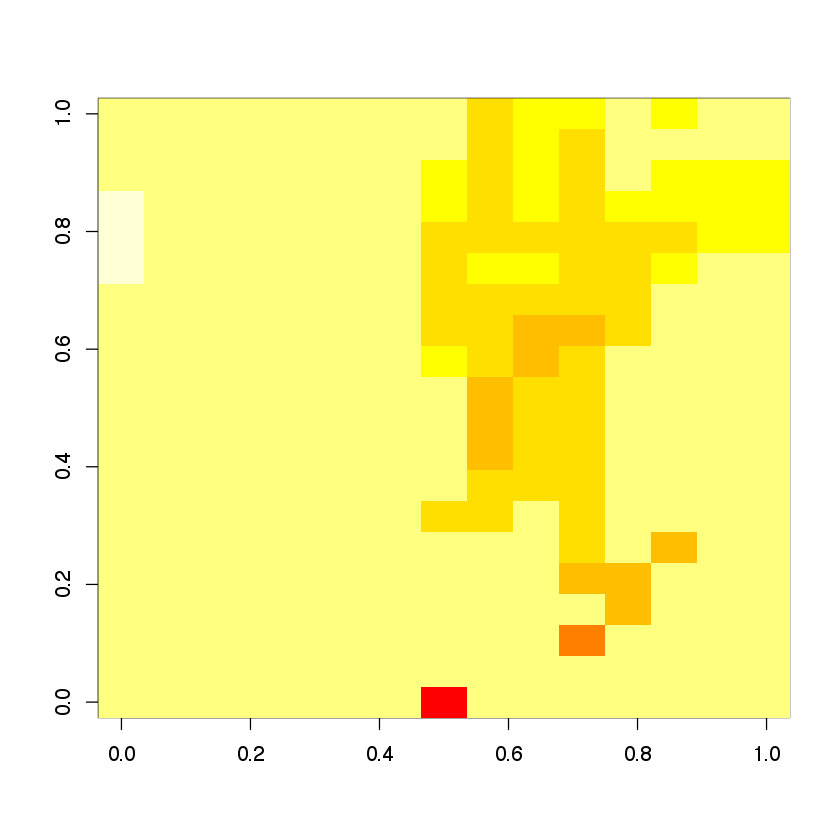

In [75]:
image(as.matrix(corr_df_BM))

In [76]:
drank_d

ERROR: Error in eval(expr, envir, enclos): object 'drank_d' not found


In [77]:
f_tiers_tau <- function(x){
    xnew = x
    xnew[abs(x)<0.33] = 0
    xnew[abs(x)>=0.33 & abs(x)<=0.6] = 0.5
    xnew[abs(x)>0.6] = 1
    return(xnew)
}

In [133]:
pdf(file =  paste(PLOT_PATH, "ranking_kendall_TM.pdf", sep='/'), 5, 4)
mar.default <- c(5,4,4,2) + 0.1
par(mar = mar.default + c(0, 1, 0, 0)) 
image(t_vec, k_vec, f_tiers_tau(abs(as.matrix(corr_df_TM))), 
        col=brewer.pal(9, "Greys"),
        xlab='Temperature [F]', ylab='n', main='Kendall tau Rank Correlation Levels (TR)',
        , cex.main=1.5, cex.lab=1.5, cex.axis=1.5)
dev.off()

pdf 
  2

In [132]:
pdf(file =  paste(PLOT_PATH, "ranking_kendall_BM.pdf", sep='/'), 5, 4)
mar.default <- c(5,4,4,2) + 0.1
par(mar = mar.default + c(0, 1, 0, 0)) 
image(t_vec, k_vec, f_tiers_tau(abs(as.matrix(corr_df_BM))), 
        col=brewer.pal(9, "Greys"),
        xlab='Temperature [F]', ylab='n', main='Kendall tau Rank Correlation Levels (BP)',
        , cex.main=1.5, cex.lab=1.5, cex.axis=1.5)
dev.off()

pdf 
  2

In [113]:
f_tiers_drank <- function(x){
    xnew = x
    xnew[abs(x)<0.9] = 0
    xnew[abs(x)>=0.9 & abs(x)<0.95] = 0.5
    xnew[abs(x)>=0.95] = 1
    return(xnew)
}

In [131]:
pdf(file =  paste(PLOT_PATH, "ranking_drank_TM.pdf", sep='/'), 5, 4)
mar.default <- c(5,4,4,2) + 0.1
par(mar = mar.default + c(0, 1, 0, 0)) 
image(t_vec, k_vec, f_tiers_drank(as.matrix(drank_p_TM)), 
        col=brewer.pal(9, "Greys"),
        xlab='Temperature [F]', ylab='n', main='P(d=0) Levels (TR)',
        , cex.main=1.5, cex.lab=1.5, cex.axis=1.5)
dev.off()

pdf 
  2

In [130]:
pdf(file =  paste(PLOT_PATH, "ranking_drank_BM.pdf", sep='/'), 5, 4)
mar.default <- c(5,4,4,2) + 0.1
par(mar = mar.default + c(0, 1, 0, 0)) 
image(t_vec, k_vec, f_tiers_drank(as.matrix(drank_p_BM)), 
        col=brewer.pal(9, "Greys"),
        xlab='Temperature [F]', ylab='n', main='P(d=0) Levels (BP)',
        , cex.main=1.5, cex.lab=1.5, cex.axis=1.5)   
dev.off()

pdf 
  2

In [116]:
drank_d0_TM = drank_d_TM / apply(drank_d_TM, 1, max)
drank_d0_BM = drank_d_BM / apply(drank_d_BM, 1, max)

In [129]:
pdf(file =  paste(PLOT_PATH, "ranking_drank_value_TM.pdf", sep='/'), 5, 4)
mar.default <- c(5,4,4,2) + 0.1
par(mar = mar.default + c(0, 1, 0, 0)) 
    image.plot(t_vec, k_vec, as.matrix(drank_d0_TM), col=brewer.pal(9,"Greys"),
               xlab='Temperature [F]', ylab='n', main='Normalized d(T;n) (TR)', cex.main=1.5, cex.lab=1.5, cex.axis=1.5)
dev.off()

pdf 
  2

In [134]:
pdf(file =  paste(PLOT_PATH, "ranking_drank_value_BM.pdf", sep='/'), 5, 4)
mar.default <- c(5,4,4,2) + 0.1
par(mar = mar.default + c(0, 1, 0, 0)) 
    image.plot(t_vec, k_vec, as.matrix(drank_d0_BM), col=brewer.pal(9,"Greys"),
               xlab='Temperature [F]', ylab='n', main='Normalized d(T;n) (BP)', cex.main=1.5, cex.lab=1.5, cex.axis=1.5)
dev.off()

pdf 
  2

##Ranking example

In [94]:
ex_df = subset(thermal_model_df, grain=="60min" & TemperatureF>=79 & TemperatureF <=81, 
               select=c("name", "TemperatureF", "resp_avg", "resp_HVAC"))

ERROR: Error in eval(expr, envir, enclos): object 'TemperatureF' not found


In [ ]:
sort(unique(ex_df$name))

In [ ]:
y_ex = ex_df; y_ex$resp_avg = NULL
y_ex = dcast(ex_df, name ~ TemperatureF); 
rownames(y_ex) = y_ex$name; y_ex$name = NULL
y_ex = rowMeans(y_ex)
idx  = c("Arthur", "Bill", "Carl", "Dan", "Edd", "Frank", "George", "Harold", "Irving", "James")
y_ex = y_ex[idx]
idx_ord = order(abs(y_ex), decreasing=T)
y_ex = sort(abs(y_ex), decreasing=T)

X_ex = ex_df; X_ex$resp_HVAC = NULL
X_ex = dcast(X_ex, name ~ TemperatureF); 
rownames(X_ex) = X_ex$name; X_ex$name = NULL
colnames(X_ex) = paste("T =", colnames(X_ex))
X_ex = X_ex[idx[idx_ord],]
 
fin_df = round(cbind(abs(X_ex), abs(y_ex)), digits=3); names(fin_df)[4] = "\\hat{a}(T=80)"

fin_df

In [ ]:
library(xtable)
print(xtable(fin_df, type="latex", digits=3), file=paste(PLOT_PATH,"example_response_ranking.tex", sep="/"))

In [ ]:
# compute drank for example
compute_drank(y_ex, t(X_ex), B = 500)

In [ ]:
# Kendall's tau for this example
cor.test(y_ex, X_ex[['T = 80']], method="kendall")

In [ ]:
kend_df = data.frame(names(sort(y_ex, decreasing=T)), rownames(X_ex)[order(X_ex['T = 80'], decreasing=T)])
names(kend_df) = c("a(T=80F)", "\\hat{a}(T=90F)")
kend_df

In [ ]:
print(xtable(kend_df, type="latex"), file=paste(PLOT_PATH,"example_ranking_80F.tex", sep="/"))

##Occupancy validation

In [ ]:
str(thermal_model[[1]])